In [ ]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os


In [ ]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/188564
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(
    name="wine", 
    version=1, 
    description="Read from wine dataset",
    labels=["quality"],
    query=query)
    

In [ ]:
while True:
    X_train, X_test, y_train, y_test = feature_view.train_test_split(0.3)
    if 9 in y_test['quality'].values and 3 in y_test['quality'].values and 3 in y_train['quality'].values and 9 in y_train['quality'].values: 
        break

Finished: Reading data from Hopsworks, using ArrowFlight (2.56s) 


In [ ]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=9)

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
metrics = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
print(metrics)
print(accuracy)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '4': {'precision': 0.5, 'recall': 0.058823529411764705, 'f1-score': 0.10526315789473684, 'support': 68}, '5': {'precision': 0.5514705882352942, 'recall': 0.5882352941176471, 'f1-score': 0.5692599620493359, 'support': 510}, '6': {'precision': 0.4789533560864619, 'recall': 0.621861152141802, 'f1-score': 0.5411311053984575, 'support': 677}, '7': {'precision': 0.4155844155844156, 'recall': 0.23443223443223443, 'f1-score': 0.2997658079625293, 'support': 273}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 49}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.4974779319041614, 'macro avg': {'precision': 0.27800119427231024, 'recall': 0.21476460144334977, 'f1-score': 0.21648857618643705, 'support': 1586}, 'weighted avg': {'precision': 0.47475155581657014, 'recall': 0.4974779319041614, 'f1-score': 0.4701527738401826, 'support': 1586}}
0.4974779319041614


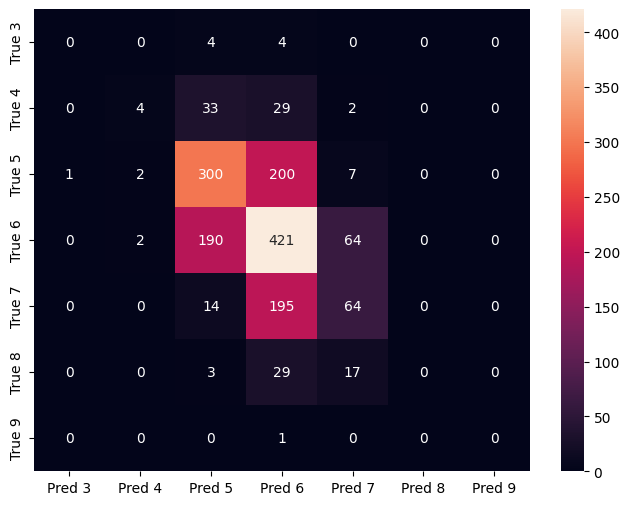

In [ ]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(conf_matrix, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], 
                     ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])

plt.figure(figsize=(8, 6))
cm = sns.heatmap(df_cm, annot=True, fmt='.0f')
fig = cm.get_figure()
plt.show()

In [ ]:
mr = project.get_model_registry()

model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save model and confusion matrix to the model dir
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, description, metrics
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy": metrics["accuracy"]},
    model_schema=model_schema,
    description="Wine quality predictor"
)

# Upload the model to the model registry
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/30503 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/493670 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/683 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/188564/models/wine_model/1


Model(name: 'wine_model', version: 1)